In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Mosaic
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1HODufez2f0zsSry19U79UyZYS7hi9iIn/Mosaic
'Copy of CS445_Final_Project.ipynb'				 images.tar.gz
 CS445_Final_Project.ipynb					 raw_images
 Gilbert_Stuart_Williamstown_Portrait_of_George_Washington.jpg


In [2]:
#import tarfile
#file = tarfile.open('images.tar.gz')
#file.extractall('./raw_images')

In [3]:
# System imports
from os import path
from os import listdir
import os
import math
import random

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda
from scipy.interpolate import griddata

# Same folder as project notebook
datadir = "./"
# Target image
target_image = "Gilbert_Stuart_Williamstown_Portrait_of_George_Washington.jpg"
# Image folder name
images_folder = datadir + "raw_images/images/"

In [4]:
# Read images names from directory
image_files_names = [images_folder+f for f in os.listdir(images_folder) if path.isfile(path.join(images_folder, f)) and f.endswith(('.jpg', '.png', 'jpeg'))]
# Print number of images
print(len(image_files_names))
# Print image name example
print(image_files_names[1])

17838
./raw_images/images/Barack Obama_220.jpg


In [5]:
def read_image(image_path: str) -> np.ndarray:
    '''
    Reads image from image path, and
    return floating point RGB image

    Args:
        image_path: path to image

    Returns:
        RGB image of shape H x W x 3 in floating point format
    '''
    # read image and convert to RGB
    bgr_image = cv2.imread(image_path)
    if bgr_image.shape[2] > 1:
        rgb_image = bgr_image[:, :, [2, 1, 0]]
    return rgb_image.astype(np.float32) / 255

In [6]:
def crop_image(img: np.ndarray) -> np.ndarray:
  height, width = img.shape[:2]
  crop_to = min(height, width)
  x, y = (width - crop_to) // 2, (height - crop_to) // 2
  return img[y:y+crop_to, x:x+crop_to]

def load_components(filenames: list[str], target_size: tuple[int]) -> np.ndarray:
  cropped_resized = []

  for file in filenames:
    img = read_image(file)
    img = crop_image(img)
    cropped_resized.append(cv2.resize(img, target_size))

  return np.stack(cropped_resized, axis=0)

target_size = (160, 160)
components = load_components(image_files_names, target_size)

(17838, 160, 160, 3)


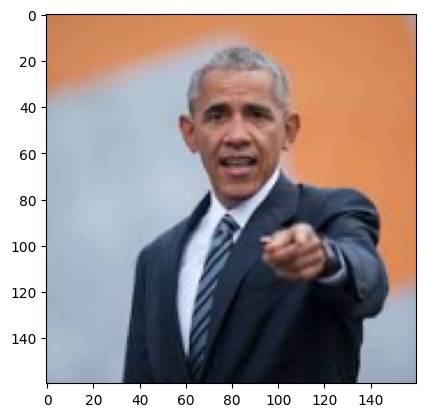

In [7]:
print(components.shape)
plt.imshow(components[11])

(4628, 4628, 3)


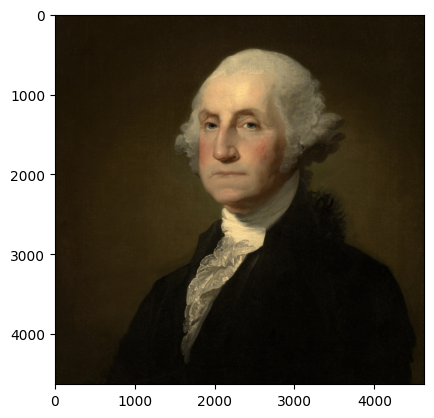

In [8]:
# Read target image:
target = crop_image(read_image(datadir + target_image))
print(target.shape)
plt.figure()
plt.imshow(target)

In [9]:
#Number of horizontal and vertical mosaic tiles:
H_tiles = int(target.shape[1]/160)
V_tiles = int(target.shape[0]/160)

print("Number of 160x160 tiles: ", H_tiles,"x", V_tiles," total = ", H_tiles * V_tiles)

Number of 160x160 tiles:  28 x 28  total =  784


In [10]:
def section_target_image(target_img, tile_size):
    sections = []
    for y in range(0, target.shape[0], tile_size[1]):
        for x in range(0, target.shape[1], tile_size[0]):
            section = target[y:y + tile_size[1], x:x + tile_size[0]]
            if section.shape[0] == tile_size[1] and section.shape[1] == tile_size[0]:
                sections.append(section)
    return sections

sections = section_target_image(target_image, (160,160))

784


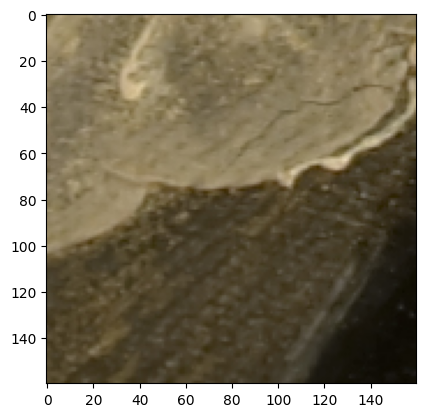

In [11]:
print(len(sections))
plt.imshow(sections[600])

In [12]:
import math
import numpy as np
from numba import cuda

@cuda.jit
def batch_compare_images_gpu(img1, img_batch, result):
    idx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if idx < img_batch.shape[0]:
        squared_sum = 0
        for i in range(img1.shape[0]):
            for j in range(img1.shape[1]):
                for k in range(img1.shape[2]):
                    diff = img1[i, j, k] - img_batch[idx, i, j, k]
                    squared_sum += diff ** 2
        result[idx] = math.sqrt(squared_sum)

def batch_compare_images(img1, img_batch):
    result = np.empty(img_batch.shape[0], dtype=np.float32)
    threads_per_block = 32
    blocks_per_grid = (img_batch.shape[0] + threads_per_block - 1) // threads_per_block

    img1_contiguous = np.ascontiguousarray(img1.astype(np.float32))
    img_batch_contiguous = np.ascontiguousarray(img_batch.astype(np.float32))
    
    img1_gpu = cuda.to_device(img1_contiguous)
    img_batch_gpu = cuda.to_device(img_batch_contiguous)
    result_gpu = cuda.to_device(result)

    batch_compare_images_gpu[blocks_per_grid, threads_per_block](img1_gpu, img_batch_gpu, result_gpu)

    result_gpu.copy_to_host(result)
    return result

def find_top_n_matches(section, component_images_array, n):
    similarities = batch_compare_images(section, component_images_array)
    top_n_indices = np.argsort(similarities)[:n]
    return [component_images_array[i] for i in top_n_indices]


In [17]:
import time

def choose_components(sections, components):
  selected_components = []
  n = len(sections)

  for i, section in enumerate(sections):
    top_5_components = find_top_n_matches(section, components, 5)
    random_index = random.randint(0,4)
    selected_components.append(top_5_components[random_index])
    print(f'{i+1}/{n} sections complete')

  return selected_components

In [30]:
def get_mosaic(selected_components, rows, cols):
  mosaic = np.array(selected_components)
  mosaic = mosaic.reshape(V_tiles, H_tiles, 160, 160, 3)
  
  rows = []
  for r in range(V_tiles):
      row = np.hstack([mosaic[r, c] for c in range(H_tiles)])
      rows.append(row)
  mosaic = np.vstack(rows)
  
  return mosaic

Elapsed time: 0.0 minutes


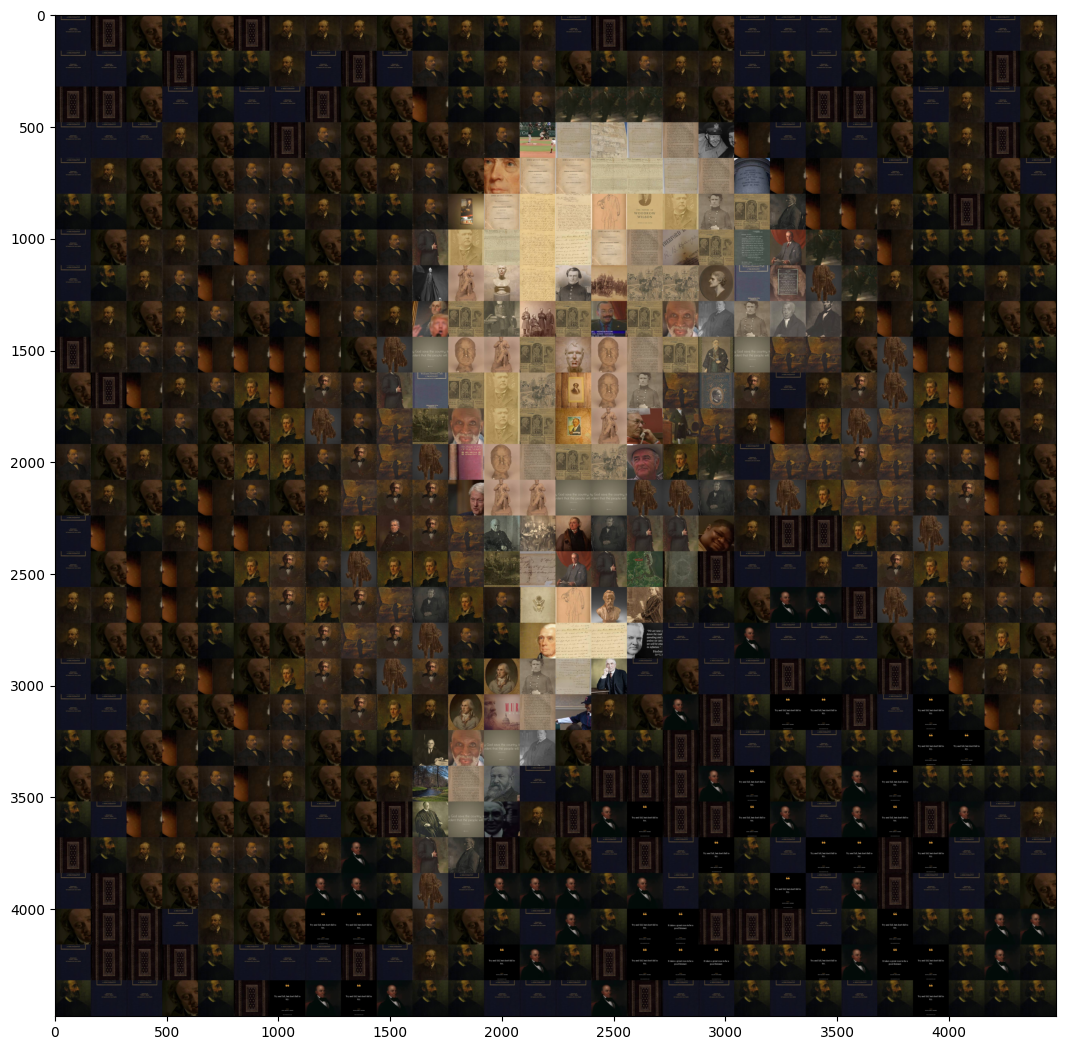

In [32]:
start_time = time.time()
#selected_components = choose_components(sections, components)
output = get_mosaic(selected_components, V_tiles, H_tiles)
elapsed_time = (time.time() - start_time)//60
print(f'Elapsed time: {elapsed_time} minutes')
plt.figure(figsize=(13, 13))
plt.imshow(output)